In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
import cv2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import random

C:\Users\lobna\AppData\Local\Temp\ipykernel_3908\1068878690.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
# Paths to dataset directories
train_dir = r"C:\Users\lobna\Desktop\Pattern Project\Dataset\train"
test_dir = r"C:\Users\lobna\Desktop\Pattern Project\Dataset\test"

# Function to load images from a directory
def load_images_from_directory(directory, target_size=(128, 128)):
    data = []
    labels = []
    classes = os.listdir(directory)  
    for label, class_name in enumerate(classes):
        class_folder = os.path.join(directory, class_name)
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):
                filepath = os.path.join(class_folder, filename)
                if filepath.endswith((".png", ".jpg", ".jpeg")):  
                    try:
                        img = imread(filepath) 
                        img_resized = resize(img, target_size)  
                        data.append(img_resized)
                        labels.append(label)
                    except Exception as e:
                        print(f"Error loading image {filepath}: {e}")
    return np.array(data), np.array(labels)

# Load train and test datasets
train_data, train_labels = load_images_from_directory(train_dir)
test_data, test_labels = load_images_from_directory(test_dir)

# Print dataset shapes
print(f"Train data shape: {train_data.shape}, Train labels shape: {train_labels.shape}")
print(f"Test data shape: {test_data.shape}, Test labels shape: {test_labels.shape}")


Train data shape: (9305, 128, 128, 3), Train labels shape: (9305,)
Test data shape: (200, 128, 128, 3), Test labels shape: (200,)


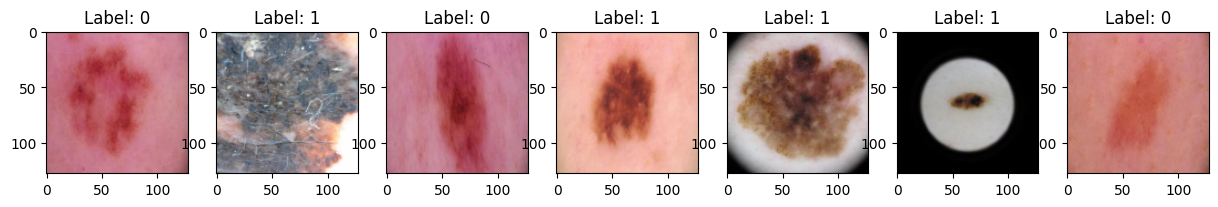

In [ ]:
def display_images(images, labels=None, num_images=7):
    indices = random.sample(range(len(images)), num_images)  
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx])  
        plt.axis('on')  
        if labels is not None:
            plt.title(f"Label: {labels[idx]}")  
    plt.show()
    return indices 
random_indices = display_images(train_data, train_labels, num_images=7)

In [ ]:
def convert_to_grayscale(images):
    grayscale_images = [rgb2gray(image) for image in images]
    return np.array(grayscale_images)

train_data_gray = convert_to_grayscale(train_data)
test_data_gray = convert_to_grayscale(test_data)

print(f"Train data shape (grayscale): {train_data_gray.shape}")
print(f"Test data shape (grayscale): {test_data_gray.shape}")


Train data shape (grayscale): (9305, 128, 128)
Test data shape (grayscale): (200, 128, 128)


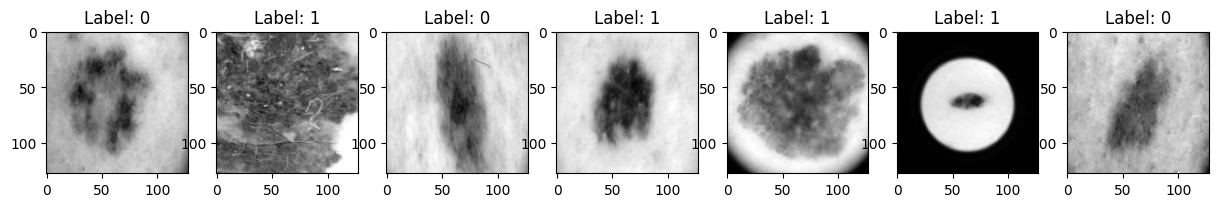

In [13]:
def display_grayscale_images(images, labels, indices, num_images=7):
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):  
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx], cmap="gray")  
        plt.axis('on')
        plt.title(f"Label: {labels[idx]}")  
    plt.show()
display_grayscale_images(train_data_gray, train_labels, indices=random_indices, num_images=7)

In [11]:
def normalize_image(img):
    img_min = np.min(img)
    img_max = np.max(img)
    return ((img - img_min) / (img_max - img_min) * 255).astype(np.uint8)

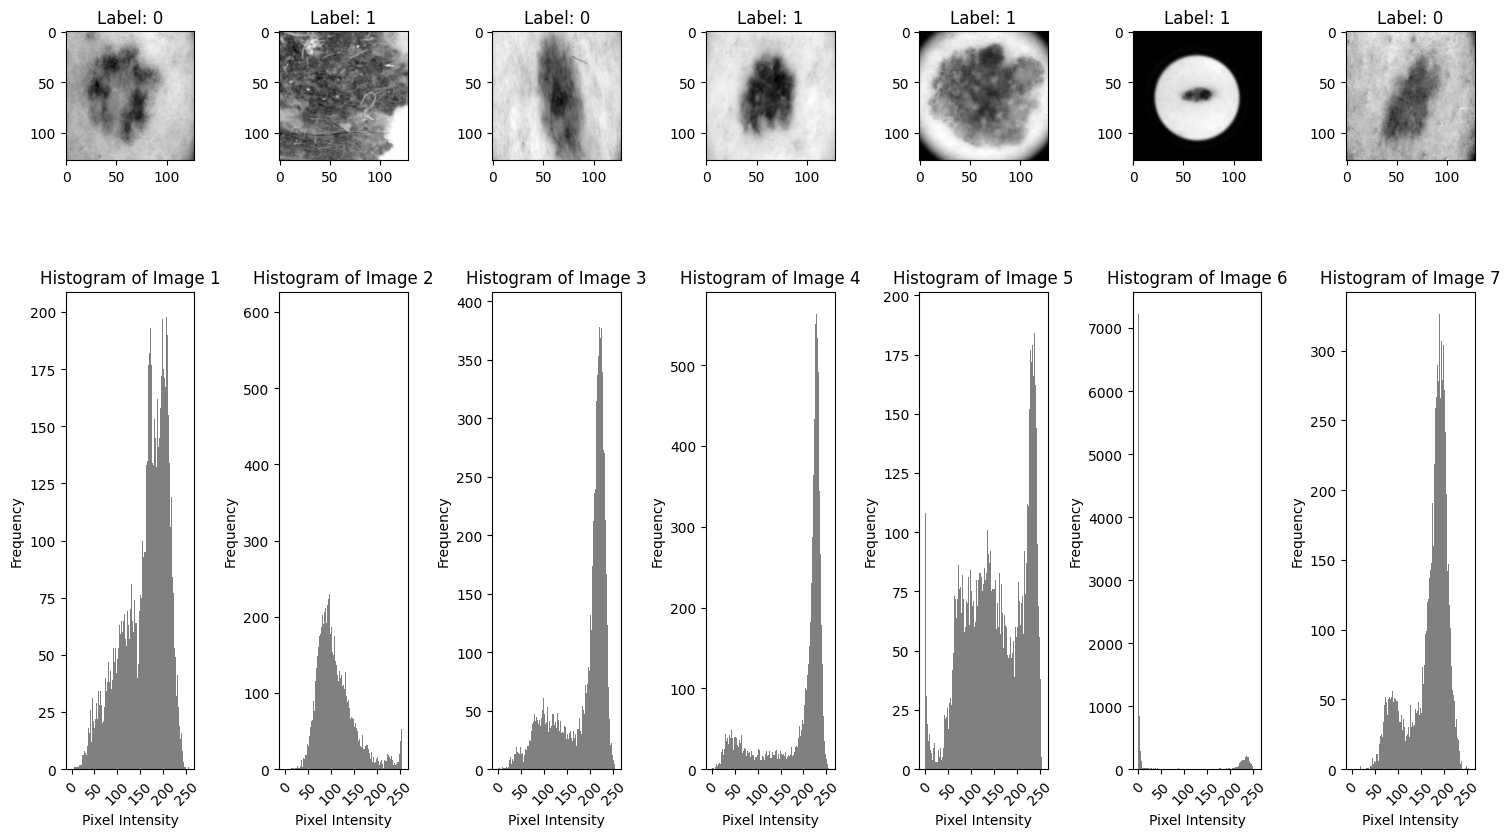

In [12]:
def display_images_and_histograms(images, labels, indices, num_images=5):
    
    plt.figure(figsize=(15, 10))

    for i, idx in enumerate(indices):
       
        normalized_img = normalize_image(images[idx])

        plt.subplot(2, num_images, i + 1)
        plt.imshow(normalized_img, cmap="gray")
        plt.axis('on')
        plt.title(f"Label: {labels[idx]}")

        plt.subplot(2, num_images, num_images + i + 1)
        plt.hist(normalized_img.ravel(), bins=256, range=(0, 255), color='gray')
        plt.title(f"Histogram of Image {i + 1}")
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.xticks(np.arange(0, 256, 50),rotation=45)

    plt.tight_layout()
    plt.show()

display_images_and_histograms(train_data_gray, train_labels, random_indices, num_images=7)

# **Using Feature Extraction Methods: Otsu method**

# **Otsu Method**


In [15]:
def otsu_threshold(image):
    
    _, otsu_binary = cv2.threshold(
        image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    return otsu_binary

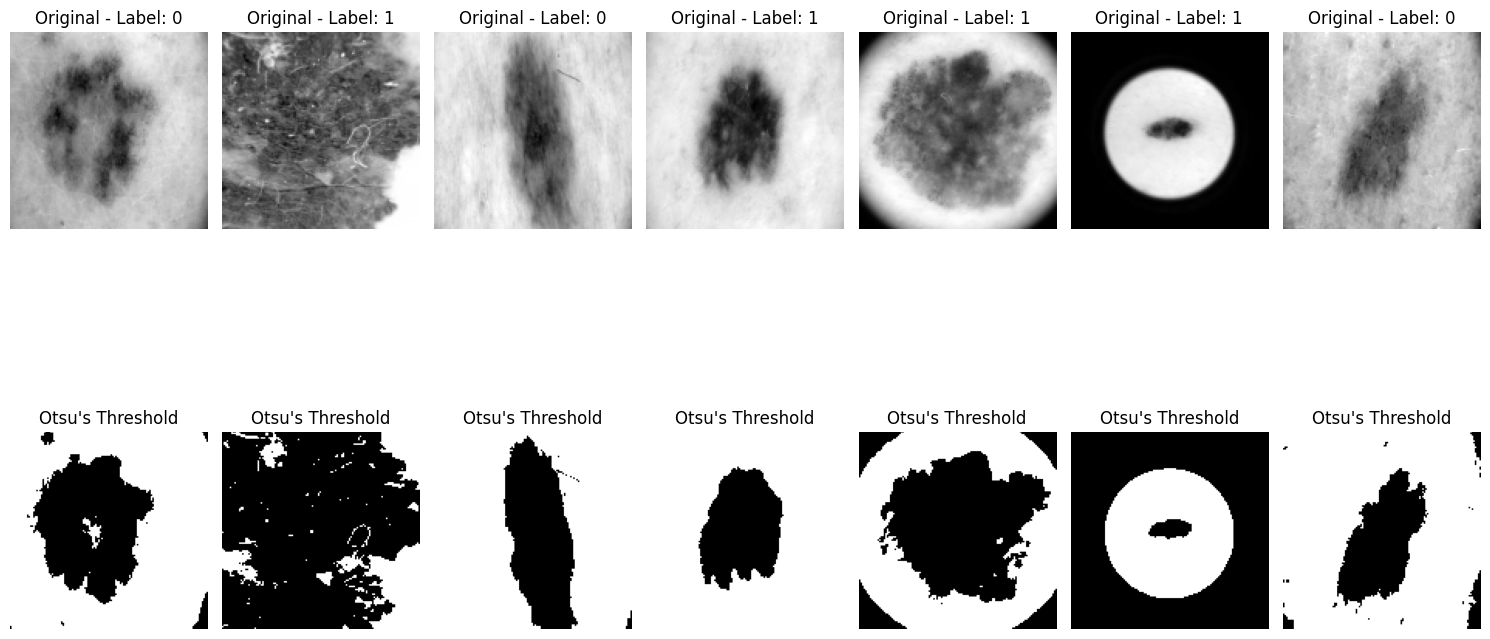

In [16]:
def display_otsu_detection(images, labels, indices, num_images=7):
    
    plt.figure(figsize=(15, 10))

    for i, idx in enumerate(indices):
      
        normalized_img = normalize_image(images[idx])

       
        otsu_img = otsu_threshold(normalized_img)

        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(normalized_img, cmap="gray")
        plt.axis('off')
        plt.title(f"Original - Label: {labels[idx]}")

       
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(otsu_img, cmap="gray")
        plt.axis('off')
        plt.title("Otsu's Threshold")

    plt.tight_layout()
    plt.show()
display_otsu_detection(train_data_gray, train_labels, random_indices, num_images=7)

# **Scaling and flatening data for training and testing the model , Using 3 Algorithms: Logistic, KNN, Random Forest.**

In [22]:
class_names = os.listdir(test_dir)

train_data_flat = train_data.reshape(train_data.shape[0], -1)  
test_data_flat = test_data.reshape(test_data.shape[0], -1)  

In [23]:
#scaling
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data_flat)
test_data_scaled = scaler.transform(test_data_flat)

In [24]:
model = LogisticRegression(max_iter=1000) 

model.fit(train_data_scaled, train_labels)

predictions = model.predict(test_data_scaled)

train_accuracy = accuracy_score(train_labels, model.predict(train_data_scaled))

test_accuracy = accuracy_score(test_labels, model.predict(test_data_scaled))

report_lr = classification_report(test_labels, predictions, target_names=class_names)

print(f"Training accuracy: {train_accuracy}")
print(f"Test accuracy: {test_accuracy}")
print("Classification Report:")
print(report_lr)


Training accuracy: 1.0
Test accuracy: 0.855
Classification Report:
              precision    recall  f1-score   support

      benign       0.83      0.89      0.86       100
   malignant       0.88      0.82      0.85       100

    accuracy                           0.85       200
   macro avg       0.86      0.85      0.85       200
weighted avg       0.86      0.85      0.85       200



In [25]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

rf_model.fit(train_data_scaled, train_labels)

rf_train_accuracy = accuracy_score(train_labels, rf_model.predict(train_data_scaled))

rf_test_accuracy = accuracy_score(test_labels, rf_model.predict(test_data_scaled))

rf_predictions = rf_model.predict(test_data_scaled)

report_rf = classification_report(test_labels, rf_predictions, target_names=class_names)


print(f"Random Forest Training accuracy: {rf_train_accuracy}")
print(f"Random Forest Test accuracy: {rf_test_accuracy}")
print("Random Forest Classification Report:")
print(report_rf)


Random Forest Training accuracy: 0.9644277270284793
Random Forest Test accuracy: 0.905
Random Forest Classification Report:
              precision    recall  f1-score   support

      benign       0.88      0.94      0.91       100
   malignant       0.94      0.87      0.90       100

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.90       200
weighted avg       0.91      0.91      0.90       200



In [26]:
knn_model = KNeighborsClassifier(n_neighbors=10)

knn_model.fit(train_data_scaled, train_labels)

knn_train_accuracy = accuracy_score(train_labels, knn_model.predict(train_data_scaled))

knn_test_accuracy = accuracy_score(test_labels, knn_model.predict(test_data_scaled))

knn_prediction =  knn_model.predict(test_data_scaled)

report_knn = classification_report(test_labels, knn_prediction, target_names=class_names)


print(f"KNN Training accuracy: {knn_train_accuracy}")
print(f"KNN Test accuracy: {knn_test_accuracy}")
print("KNN Classification Report:")
print(report_knn)


KNN Training accuracy: 0.8825362708221386
KNN Test accuracy: 0.88
KNN Classification Report:
              precision    recall  f1-score   support

      benign       0.82      0.97      0.89       100
   malignant       0.96      0.79      0.87       100

    accuracy                           0.88       200
   macro avg       0.89      0.88      0.88       200
weighted avg       0.89      0.88      0.88       200



# **Since Random Forest algorithm the one with the highest test accuracy achieving 0.9 it will be used to visualize and make predictions**

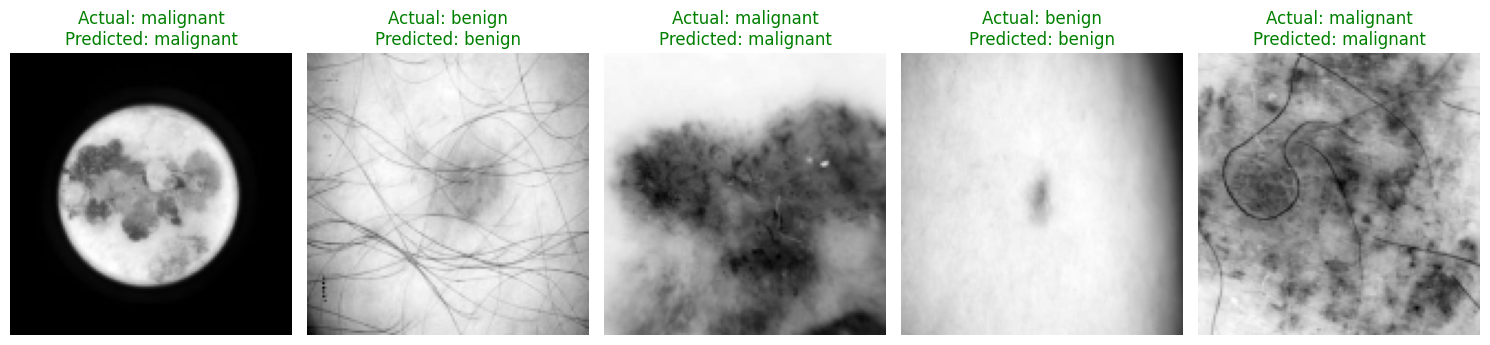

In [29]:
random_indices = random.sample(range(len(test_data_gray)), k=5)

def display_predictions(images, true_labels, predicted_labels, class_names, indices, num_images=5):

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices[:num_images]):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(normalize_image(images[idx]), cmap='gray')
        plt.axis('off')
        color = 'green' if true_labels[idx] == predicted_labels[idx] else 'red'
        plt.title(
            f"Actual: {class_names[true_labels[idx]]}\nPredicted: {class_names[predicted_labels[idx]]}",
            color=color
        )
    plt.tight_layout()
    plt.show()

display_predictions(test_data_gray, test_labels, rf_predictions, class_names, random_indices, num_images=5)